In [1]:
import mnist_balance_generator
from mnist_balance_generator import *

import torch
from torch.nn import Module
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from torchvision import models

import random
from copy import deepcopy

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

from imblearn.metrics import (geometric_mean_score, sensitivity_score, 
                              specificity_score)
from sklearn.metrics import (balanced_accuracy_score, precision_score, 
                             recall_score, f1_score)


import scipy as sc
import matplotlib.style

params = {'legend.fontsize': 14,
          'axes.labelsize': 14,
          'axes.titlesize': 14,
          'xtick.labelsize' :14,
          'ytick.labelsize': 13,
          'grid.color': 'k',
          'grid.linestyle': ':',
          'grid.linewidth': 0.8,
          'mathtext.fontset' : 'stix',
          'mathtext.rm'      : 'serif',
          'font.family'      : 'serif',
          'font.serif'       : "Times New Roman", # or "Times"          
         }
matplotlib.rcParams.update(params)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
if torch.cuda.is_available():
    print("life is good")

device = torch.device("cuda")

life is good


In [3]:
dataset = 'MNIST'
seeds = [1, 2, 3]
epochs=150

In [4]:
if dataset == 'MNIST':
    trainloader = trainloader_MNIST
    validloader = validloader_MNIST
    testloader = testloader_MNIST

    classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')
    
    output_size_network = len(classes)

In [5]:
class LeNet(Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(2, stride=2)
        self.fc1 = nn.Linear(256, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.relu5 = nn.ReLU()

    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        y = y.view(y.shape[0], -1)
        y = self.fc1(y)
        y = self.relu3(y)
        y = self.fc2(y)
        y = self.relu4(y)
        y = self.fc3(y)
        y = self.relu5(y)
        return y

model1 = LeNet()
model1= nn.DataParallel(model1)
model1 = model1.to(device)

model2 = LeNet()
model2= nn.DataParallel(model2)
model2 = model2.to(device)

model3 = LeNet()
model3= nn.DataParallel(model3)
model3 = model3.to(device)

In [6]:
model4 = models.resnet18(pretrained=False)
model4.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model4.fc.in_features
model4.fc = nn.Linear(num_ftrs, output_size_network)
model4 = nn.DataParallel(model4)
model4 = model4.to(device)

model5 = models.resnet18(pretrained=False)
model5.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model5.fc.in_features
model5.fc = nn.Linear(num_ftrs, output_size_network)
model5 = nn.DataParallel(model5)
model5 = model5.to(device)

model6 = models.resnet18(pretrained=False)
model6.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_ftrs = model6.fc.in_features
model6.fc = nn.Linear(num_ftrs, output_size_network)
model6 = nn.DataParallel(model6)
model6 = model6.to(device)

In [7]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=output_size_network):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model7 = ConvNet()
model7 = nn.DataParallel(model7)
model7 = model7.to(device)

model8 = ConvNet()
model8 = nn.DataParallel(model8)
model8 = model8.to(device)

model9 = ConvNet()
model9 = nn.DataParallel(model9)
model9 = model9.to(device)

In [8]:
modelLeNet = [model1, model2, model3] 
modelResNet = [model4, model5, model6]
modelConvNet = [model7, model8, model9]
model = [modelLeNet, modelResNet, modelConvNet]

In [9]:
criterion = nn.CrossEntropyLoss()

optimizer1 = optim.SGD(model1.parameters(), lr=0.1)
optimizer2 = optim.SGD(model2.parameters(), lr=0.1)
optimizer3 = optim.SGD(model3.parameters(), lr=0.1)
optimizer4 = optim.SGD(model4.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
optimizer5 = optim.SGD(model5.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
optimizer6 = optim.SGD(model6.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
optimizer7 = optim.SGD(model7.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
optimizer8 = optim.SGD(model8.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
optimizer9 = optim.SGD(model9.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

optimizer = [[optimizer1, optimizer2, optimizer3], [optimizer4, optimizer5, optimizer6], [optimizer7, optimizer8, optimizer9]]

val_loss_min1 = np.Inf
val_loss_min2 = np.Inf
val_loss_min3 = np.Inf
val_loss_min4 = np.Inf
val_loss_min5 = np.Inf
val_loss_min6 = np.Inf
val_loss_min7 = np.Inf
val_loss_min8 = np.Inf
val_loss_min9 = np.Inf

val_loss_min = [[val_loss_min1, val_loss_min2, val_loss_min3], [val_loss_min4, val_loss_min5, val_loss_min6], [val_loss_min7, val_loss_min8, val_loss_min9]]

networks = [0, 1, 2]

In [10]:
train_loss_hist = []
val_loss_hist = []

for network in zip(networks):
    network = int(''.join(map(str, network)))

    for seed in zip(seeds): 
        seed = int(''.join(map(str, seed)))
    
        print('-------------------')
        print('SEED:', seed)
        if network == 0:
            print('MODEL: LeNet')
        elif network == 1:
            print('MODEL: ResNet')
        elif network == 2:
            print('MODEL: ConvNet')
        print('-------------------')

        np.random.seed((seed+1)*((seed+network)**(network+1)))
        torch.manual_seed((seed+1)*((seed+network)**(network+1)))
        random.seed((seed+1)*((seed+network)**(network+1)))
        torch.cuda.manual_seed((seed+1)*((seed+network)**(network+1)))

        for epoch in range(1, epochs+1):  
            train_loss = 0.0
            val_loss = 0.0

            model[network][seed-1].train()
            for data, labels in trainloader:
                data, labels = data.to(device), labels.to(device)
                optimizer[network][seed-1].zero_grad()
                outputs = model[network][seed-1](data)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer[network][seed-1].step()

                train_loss += loss.item()

            model[network][seed-1].eval()

            with torch.no_grad():
                for data, labels in validloader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = model[network][seed-1](data)
                    loss = criterion(outputs, labels)
            
                    val_loss += loss.item()


            train_loss = train_loss/len(trainloader)
            val_loss = val_loss/len(validloader)
            train_loss_hist.append(train_loss)
            val_loss_hist.append(val_loss)

            print('Seed: {} \tEpoch: {} \tTraining Loss: {:.3f} \tValidation Loss: {:.3f}'.format(seed, 
                epoch, train_loss, val_loss))
 

            if val_loss <= val_loss_min[network][seed-1]:
                print('Validation loss decreased ({:.3f} --> {:.3f}).  Saving model ...'.format(
                val_loss_min[network][seed-1],
                val_loss))
                torch.save({
                    'model'+str(network)+str(seed)+'_state_dict': deepcopy(model[network][seed-1].state_dict()),
                    'optimizer'+str(network)+str(seed)+'_state_dict': deepcopy(optimizer[network][seed-1].state_dict()),
                    'epoch': epoch
                           }, 'balance_mnist'+str(network)+str(seed)+str('.pt'))
                val_loss_min[network][seed-1] = val_loss
    
        if network == 0:
            print('Finished Training for seed', seed, 'of model LeNet')
        elif network == 1:
            print('Finished Training for seed', seed, 'of model ResNet')
        elif network == 2:
            print('Finished Training for seed', seed, 'of model ConvNet') 

-------------------
SEED: 1
MODEL: LeNet
-------------------
Seed: 1 	Epoch: 1 	Training Loss: 0.768 	Validation Loss: 0.138
Validation loss decreased (inf --> 0.138).  Saving model ...
Seed: 1 	Epoch: 2 	Training Loss: 0.103 	Validation Loss: 0.070
Validation loss decreased (0.138 --> 0.070).  Saving model ...
Seed: 1 	Epoch: 3 	Training Loss: 0.067 	Validation Loss: 0.074
Seed: 1 	Epoch: 4 	Training Loss: 0.052 	Validation Loss: 0.070
Validation loss decreased (0.070 --> 0.070).  Saving model ...
Seed: 1 	Epoch: 5 	Training Loss: 0.043 	Validation Loss: 0.049
Validation loss decreased (0.070 --> 0.049).  Saving model ...
Seed: 1 	Epoch: 6 	Training Loss: 0.034 	Validation Loss: 0.056
Seed: 1 	Epoch: 7 	Training Loss: 0.029 	Validation Loss: 0.055
Seed: 1 	Epoch: 8 	Training Loss: 0.025 	Validation Loss: 0.054
Seed: 1 	Epoch: 9 	Training Loss: 0.022 	Validation Loss: 0.059
Seed: 1 	Epoch: 10 	Training Loss: 0.019 	Validation Loss: 0.045
Validation loss decreased (0.049 --> 0.045).  Sa

In [11]:
def model_hist_splitter(train_loss_hist):
    return [train_loss_hist[i*len(train_loss_hist) // len(networks): (i+1)*len(train_loss_hist) // len(networks)] for i in range(len(networks))]

def model_seed_splitter(train_loss_hist):
    return [train_loss_hist[i*len(train_loss_hist) // len(seeds): (i+1)*len(train_loss_hist) // len(seeds)] for i in range(len(seeds))]

In [12]:
train_model_split = model_hist_splitter(train_loss_hist)
LeNet_hist = model_seed_splitter(train_model_split[0])
ResNet_hist = model_seed_splitter(train_model_split[1])
ConvNet_hist = model_seed_splitter(train_model_split[2])

LeNet_avg = np.average(LeNet_hist, axis=0) 
ResNet_avg = np.average(ResNet_hist, axis=0) 
ConvNet_avg = np.average(ConvNet_hist, axis=0) 

LeNet_std = np.std(LeNet_hist, axis=0)
ResNet_std = np.std(ResNet_hist, axis=0)
ConvNet_std = np.std(ConvNet_hist, axis=0)

a = np.arange(len(LeNet_avg))
b = np.arange(len(ResNet_avg))
c = np.arange(len(ConvNet_avg))

In [13]:
val_model_split = model_hist_splitter(val_loss_hist)
LeNet_val_hist = model_seed_splitter(val_model_split[0])
ResNet_val_hist = model_seed_splitter(val_model_split[1])
ConvNet_val_hist = model_seed_splitter(val_model_split[2])

LeNet_val_avg = np.average(LeNet_val_hist, axis=0)
ResNet_val_avg = np.average(ResNet_val_hist, axis=0)
ConvNet_val_avg = np.average(ConvNet_val_hist, axis=0)

LeNet_val_std = np.std(LeNet_val_hist, axis=0)
ResNet_val_std = np.std(ResNet_val_hist, axis=0)
ConvNet_val_std = np.std(ConvNet_val_hist, axis=0)

x = np.arange(len(LeNet_val_avg))
y = np.arange(len(ResNet_val_avg))
z = np.arange(len(ConvNet_val_avg))

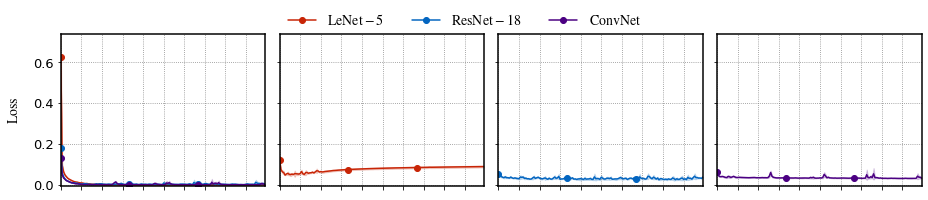

In [14]:
fig, axes = plt.subplots(1 ,4, sharey=True)
fig.set_size_inches(13, 2.5)
sns.set_style("whitegrid")

#Training Plot
axes[0].plot(a, LeNet_avg, color='#C82506', marker='o', markevery=50)
axes[0].fill_between(a, LeNet_avg - LeNet_std, LeNet_avg + LeNet_std, color='#C82506', alpha=0.2)

axes[0].plot(b, ResNet_avg, color='#0365C0', marker='o', markevery=50)
axes[0].fill_between(b, ResNet_avg - ResNet_std, ResNet_avg + ResNet_std, color='#0365C0', alpha=0.2)

axes[0].plot(c, ConvNet_avg, color='indigo', marker='o', markevery=50)
axes[0].fill_between(c, ConvNet_avg - ConvNet_std, ConvNet_avg + ConvNet_std, color='indigo', alpha=0.2)

#Validation Plots
axes[1].plot(x, LeNet_val_avg, color='#C82506', marker='o', markevery=50, label=r'$\mathrm{LeNet-5}$')
axes[1].fill_between(x, LeNet_val_avg - LeNet_val_std, LeNet_val_avg + LeNet_val_std, color='#C82506', alpha=0.2)

axes[2].plot(y, ResNet_val_avg, color='#0365C0', marker='o', markevery=50, label=r'$\mathrm{ResNet-18}$')
axes[2].fill_between(y, ResNet_val_avg - ResNet_val_std, ResNet_val_avg + ResNet_val_std, color='#0365C0', alpha=0.2)

axes[3].plot(z, ConvNet_val_avg, color='indigo', marker='o', markevery=50, label=r'$\mathrm{ConvNet}$')
axes[3].fill_between(z, ConvNet_val_avg - ConvNet_val_std, ConvNet_val_avg + ConvNet_val_std, color='indigo', alpha=0.2)

fig.legend(loc='center', bbox_to_anchor=(0.5, 1.02), ncol=3, frameon=False, labelcolor='black')

axes[0].set_ylabel(r'$\mathrm{Loss}$')
axes[0].yaxis.labelpad = 12

axes[0].grid(color="gray")
axes[0].margins(x=0)
axes[0].margins(y=0)

axes[1].grid(color="gray")
axes[1].margins(x=0)
axes[1].margins(y=0)

axes[2].grid(color="gray")
axes[2].margins(x=0)
axes[2].margins(y=0)

axes[3].grid(color="gray")
axes[3].margins(x=0)
axes[3].margins(y=0)

axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[2].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[3].xaxis.set_major_locator(MaxNLocator(integer=True))

for axis in ['top','bottom','left','right']:
    axes[0].spines[axis].set_color('0')
    axes[1].spines[axis].set_color('0')
    axes[2].spines[axis].set_color('0')
    axes[3].spines[axis].set_color('0')

for axis in ['top','bottom','left','right']:
    axes[0].spines[axis].set_linewidth(1.5)
    axes[1].spines[axis].set_linewidth(1.5)
    axes[2].spines[axis].set_linewidth(1.5)
    axes[3].spines[axis].set_linewidth(1.5)

axes[0].axes.xaxis.set_ticklabels([])
axes[1].axes.xaxis.set_ticklabels([])
axes[2].axes.xaxis.set_ticklabels([])
axes[3].axes.xaxis.set_ticklabels([])

plt.savefig("mnist_balance_final.png", bbox_inches='tight', dpi=1200)
plt.tight_layout()

In [15]:
device = torch.device("cuda")

checkpoint1 = torch.load('balance_mnist01.pt')
model1.load_state_dict(checkpoint1['model01_state_dict'])
optimizer1.load_state_dict(checkpoint1['optimizer01_state_dict'])
epoch1 = checkpoint1['epoch']
model1.to(device)

checkpoint2 = torch.load('balance_mnist02.pt')
model2.load_state_dict(checkpoint2['model02_state_dict'])
optimizer2.load_state_dict(checkpoint2['optimizer02_state_dict'])
epoch2 = checkpoint2['epoch']
model2.to(device)

checkpoint3 = torch.load('balance_mnist03.pt')
model3.load_state_dict(checkpoint3['model03_state_dict'])
optimizer3.load_state_dict(checkpoint3['optimizer03_state_dict'])
epoch3 = checkpoint3['epoch']
model3.to(device)

checkpoint4 = torch.load('balance_mnist11.pt')
model4.load_state_dict(checkpoint4['model11_state_dict'])
optimizer4.load_state_dict(checkpoint4['optimizer11_state_dict'])
epoch4 = checkpoint4['epoch']
model4.to(device)

checkpoint5 = torch.load('balance_mnist12.pt')
model5.load_state_dict(checkpoint5['model12_state_dict'])
optimizer5.load_state_dict(checkpoint5['optimizer12_state_dict'])
epoch5 = checkpoint5['epoch']
model5.to(device)

checkpoint6 = torch.load('balance_mnist13.pt')
model6.load_state_dict(checkpoint6['model13_state_dict'])
optimizer6.load_state_dict(checkpoint6['optimizer13_state_dict'])
epoch6 = checkpoint6['epoch']
model6.to(device)

checkpoint7 = torch.load('balance_mnist21.pt')
model7.load_state_dict(checkpoint7['model21_state_dict'])
optimizer7.load_state_dict(checkpoint7['optimizer21_state_dict'])
epoch7 = checkpoint7['epoch']
model7.to(device)

checkpoint8 = torch.load('balance_mnist22.pt')
model8.load_state_dict(checkpoint8['model22_state_dict'])
optimizer8.load_state_dict(checkpoint8['optimizer22_state_dict'])
epoch8 = checkpoint8['epoch']
model8.to(device)

checkpoint9 = torch.load('balance_mnist23.pt')
model9.load_state_dict(checkpoint9['model23_state_dict'])
optimizer9.load_state_dict(checkpoint9['optimizer23_state_dict'])
epoch9 = checkpoint9['epoch']
model9.to(device)

DataParallel(
  (module): ConvNet(
    (layer1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Linear(in_features=1568, out_features=10, bias=True)
  )
)

In [16]:
model_updated = [[model1, model2, model3], [model4, model5, model6], [model7, model8, model9]]

In [17]:
global_accuracy = []
test_loss_hist = []
labels_list = []
pred_list= []
class_accuracy_model =[]

for network in zip(networks):
    network = int(''.join(map(str, network)))

    for seed in zip(seeds): 
        seed = int(''.join(map(str, seed)))
        
        test_loss = 0.0
        correct = 0
        total = 0
        
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}
        
        model_updated[network][seed-1].eval()
        
        with torch.no_grad():
            for data, labels in testloader:
                images, labels = data.to(device), labels.to(device)
                output = model_updated[network][seed-1](images)
    
                loss = criterion(output, labels)
                test_loss += loss.item()

                _, pred = torch.max(output, 1)    

                total += labels.size(0)
                correct += (pred == labels).sum().item()
                
                for label, p in zip(labels, pred):
                    if label == p:
                        correct_pred[classes[label]] += 1
                    total_pred[classes[label]] += 1

                pred = pred.cpu().detach().numpy()
                labels = labels.cpu().detach().numpy()

                pred_list.append(pred)
                labels_list.append(labels)

        test_loss = test_loss/len(testloader)
        test_loss_hist.append(test_loss)
        
        accuracy = 100 * correct / total
        global_accuracy.append(accuracy)
        
        for classname, correct_count in correct_pred.items():
            model_seed_accuracy = 100 * float(correct_count) / total_pred[classname]
            class_accuracy_model.append(model_seed_accuracy)

In [18]:
test_model_split = model_hist_splitter(test_loss_hist)
LeNet_test_hist = model_seed_splitter(test_model_split[0])
ResNet_test_hist = model_seed_splitter(test_model_split[1])
ConvNet_test_hist = model_seed_splitter(test_model_split[2])

LeNet_test_avg = np.average(LeNet_test_hist, axis=0) 
ResNet_test_avg = np.average(ResNet_test_hist, axis=0) 
ConvNet_test_avg = np.average(ConvNet_test_hist, axis=0) 

LeNet_test_std = np.std(LeNet_test_hist, axis=0)
ResNet_test_std = np.std(ResNet_test_hist, axis=0)
ConvNet_test_std = np.std(ConvNet_test_hist, axis=0)

print('Test Loss for LeNet: {:.3f}'.format(LeNet_test_avg[0]), 'with standard deviation of {:.3f}'.format(LeNet_test_std[0]))
print('Test Loss for ResNet: {:.3f}'.format(ResNet_test_avg[0]), 'with standard deviation of {:.3f}'.format(ResNet_test_std[0]))
print('Test Loss for ConvNet: {:.3f}'.format(ConvNet_test_avg[0]), 'with standard deviation of {:.3f}'.format(ConvNet_test_std[0]))

Test Loss for LeNet: 0.042 with standard deviation of 0.000
Test Loss for ResNet: 0.025 with standard deviation of 0.001
Test Loss for ConvNet: 0.025 with standard deviation of 0.001


In [19]:
global_accuracy_new = model_hist_splitter(global_accuracy)
global_accuracy_LeNet = model_seed_splitter(global_accuracy_new[0])
global_accuracy_ResNet = model_seed_splitter(global_accuracy_new[1])
global_accuracy_ConvNet = model_seed_splitter(global_accuracy_new[2])

LeNet_average_accuracy = np.average(global_accuracy_LeNet, axis=0)
LeNet_accurcy_std = np.std(global_accuracy_LeNet, axis=0)

ResNet_average_accuracy = np.average(global_accuracy_ResNet, axis=0)
ResNet_accurcy_std = np.std(global_accuracy_ResNet, axis=0)

ConvNet_average_accuracy = np.average(global_accuracy_ConvNet, axis=0)
ConvNet_accurcy_std = np.std(global_accuracy_ConvNet, axis=0)

print('Accuracy for LeNet: {:.3f}%'.format(LeNet_average_accuracy[0]), 'with standard deviation of {:.3f}%'.format(LeNet_accurcy_std[0]))
print('Accuracy for ResNet: {:.3f}%'.format(ResNet_average_accuracy[0]), 'with standard deviation of {:.3f}%'.format(ResNet_accurcy_std[0]))
print('Accuracy for ConvNet: {:.3f}%'.format(ConvNet_average_accuracy[0]), 'with standard deviation of {:.3f}%'.format(ConvNet_accurcy_std[0]))

Accuracy for LeNet: 98.812% with standard deviation of 0.106%
Accuracy for ResNet: 99.368% with standard deviation of 0.065%
Accuracy for ConvNet: 99.268% with standard deviation of 0.054%


In [20]:
class_iterable = list(range(len(classes)))

class_accuracy_model = np.array_split(class_accuracy_model, 9)
class_acc_hist = model_hist_splitter(class_accuracy_model)

LeNet_class_acc = model_seed_splitter(class_acc_hist[0])
ResNet_class_acc = model_seed_splitter(class_acc_hist[1])
ConvNet_class_acc = model_seed_splitter(class_acc_hist[2])

LeNet_class_avg = np.average(LeNet_class_acc, axis=0).ravel()
ResNet_class_avg = np.average(ResNet_class_acc, axis=0).ravel()
ConvNet_class_avg = np.average(ConvNet_class_acc, axis=0).ravel()

LeNet_class_std = np.std(LeNet_class_acc, axis=0).ravel()
ResNet_class_std = np.std(ResNet_class_acc, axis=0).ravel()
ConvNet_class_std = np.std(ConvNet_class_acc, axis=0).ravel()

print('---------------')
print('LeNet Class Accuracy')
print('---------------')
for classname, index in zip(classes, class_iterable):
    print(classname, ': {:.2f}%'.format(LeNet_class_avg[index]), 'with standard deviation of {:.2f}%'.format(LeNet_class_std[index]))
    
print('\n')
print('---------------')
print('ResNet Class Accuracy')
print('---------------')
for classname, index in zip(classes, class_iterable):
    print(classname, ': {:.2f}%'.format(ResNet_class_avg[index]), 'with standard deviation of {:.2f}%'.format(ResNet_class_std[index]))
    
print('\n')
print('---------------')
print('ConvNet Class Accuracy')
print('---------------')
for classname, index in zip(classes, class_iterable):   
    print(classname, ': {:.2f}%'.format(ConvNet_class_avg[index]), 'with standard deviation of {:.2f}%'.format(ConvNet_class_std[index]))

---------------
LeNet Class Accuracy
---------------
0 : 99.44% with standard deviation of 0.16%
1 : 99.25% with standard deviation of 0.38%
2 : 99.14% with standard deviation of 0.23%
3 : 99.29% with standard deviation of 0.14%
4 : 99.03% with standard deviation of 0.14%
5 : 98.58% with standard deviation of 0.26%
6 : 98.17% with standard deviation of 0.23%
7 : 98.77% with standard deviation of 0.56%
8 : 98.54% with standard deviation of 0.24%
9 : 97.91% with standard deviation of 0.66%


---------------
ResNet Class Accuracy
---------------
0 : 99.78% with standard deviation of 0.00%
1 : 99.78% with standard deviation of 0.16%
2 : 99.33% with standard deviation of 0.18%
3 : 99.48% with standard deviation of 0.14%
4 : 99.55% with standard deviation of 0.00%
5 : 98.99% with standard deviation of 0.09%
6 : 99.07% with standard deviation of 0.23%
7 : 99.29% with standard deviation of 0.21%
8 : 99.66% with standard deviation of 0.09%
9 : 98.77% with standard deviation of 0.24%


---------

In [21]:
pred_list = [item for sublist in pred_list for item in sublist]
labels_list = [item for sublist in labels_list for item in sublist]

pred_list = np.array_split(pred_list, 9)
labels_list = np.array_split(labels_list, 9)

pred_model1 = pred_list[0].tolist()
pred_model2 = pred_list[1].tolist()
pred_model3 = pred_list[2].tolist()
pred_model4 = pred_list[3].tolist()
pred_model5 = pred_list[4].tolist()
pred_model6 = pred_list[5].tolist()
pred_model7 = pred_list[6].tolist()
pred_model8 = pred_list[7].tolist()
pred_model9 = pred_list[8].tolist()

labels_list = labels_list[0].tolist()

In [22]:
pred_list = [[pred_model1, pred_model2, pred_model3], [pred_model4, pred_model5, pred_model6], [pred_model7, pred_model8, pred_model9]]

f1_micro_list, f1_macro_list = [], []
gmean_micro_list, gmean_macro_list = [], []
bac_list, bac_adj_list = [], []
sens_micro_list, sens_macro_list = [], []
spec_micro_list, spec_macro_list = [], []
prec_micro_list, prec_macro_list = [], []
rec_micro_list, rec_macro_list = [], []

for network in zip(networks):
    network = int(''.join(map(str, network)))

    for seed in zip(seeds): 
        seed = int(''.join(map(str, seed)))
        
        f1_micro = f1_score(labels_list, pred_list[network][seed-1], average='micro')
        f1_macro = f1_score(labels_list, pred_list[network][seed-1], average='macro')
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)
        
        gmean_micro = geometric_mean_score(labels_list, pred_list[network][seed-1], average='micro')
        gmean_macro = geometric_mean_score(labels_list, pred_list[network][seed-1], average='macro')
        gmean_micro_list.append(gmean_micro)
        gmean_macro_list.append(gmean_macro)
        
        bac = balanced_accuracy_score(labels_list, pred_list[network][seed-1])
        bac_adj = balanced_accuracy_score(labels_list, pred_list[network][seed-1], adjusted=True)
        bac_list.append(bac)
        bac_adj_list.append(bac_adj)
        
        sens_micro = sensitivity_score(labels_list, pred_list[network][seed-1], average='micro')
        sens_macro = sensitivity_score(labels_list, pred_list[network][seed-1], average='macro')
        sens_micro_list.append(sens_micro)
        sens_macro_list.append(sens_macro)
        
        spec_micro = specificity_score(labels_list, pred_list[network][seed-1], average='micro')
        spec_macro = specificity_score(labels_list, pred_list[network][seed-1], average='macro')
        spec_micro_list.append(sens_micro)
        spec_macro_list.append(sens_macro)
                                       
        prec_micro = precision_score(labels_list, pred_list[network][seed-1], average='micro')
        prec_macro = precision_score(labels_list, pred_list[network][seed-1], average='macro')
        prec_micro_list.append(prec_micro)
        prec_macro_list.append(prec_macro)
                                       
        rec_micro = recall_score(labels_list, pred_list[network][seed-1], average='micro')
        rec_macro = recall_score(labels_list, pred_list[network][seed-1], average='macro')
        rec_micro_list.append(rec_micro)
        rec_macro_list.append(rec_macro)

In [23]:
metrics_list = [f1_micro_list, f1_macro_list, gmean_micro_list, gmean_macro_list, bac_list, bac_adj_list, sens_micro_list, sens_macro_list, spec_micro_list, spec_macro_list,
                prec_micro_list, prec_macro_list, rec_micro_list, rec_macro_list]

names = ["F1 Micro", "F1 Macro", "GMean Micro", "GMean Macro", "Balanced Accuracy", "Adjusted Balanced Accuracy", "Sensitivity Micro", "Sensitivity Macro", 
         "Specificity Micro", "Specificity Macro", "Precision Micro", "Precision Macro", "Recall Micro", "Recall Macro"]

for metric, name in zip(metrics_list, names):
    hist_splitted = model_hist_splitter(metric)

    metric_LeNet = model_seed_splitter(hist_splitted[0])
    metric_ResNet = model_seed_splitter(hist_splitted[1])
    metric_ConvNet = model_seed_splitter(hist_splitted[2])

    metric_avg_LeNet = np.average(metric_LeNet, axis=0).ravel()
    metric_std_LeNet = np.std(metric_LeNet, axis=0).ravel()

    metric_avg_ResNet = np.average(metric_ResNet, axis=0).ravel()
    metric_std_ResNet = np.std(metric_ResNet, axis=0).ravel()

    metric_avg_ConvNet = np.average(metric_ConvNet, axis=0).ravel()
    metric_std_ConvNet = np.std(metric_ConvNet, axis=0).ravel()
        
    print('---------------')
    print('MODEL: LeNet')
    print('METRIC:', name)
    print('---------------')
    print(' {:.2f}'.format(metric_avg_LeNet[0]), 'with standard deviation of {:.2f}'.format(metric_std_LeNet[0]))
    
    print('---------------')
    print('MODEL: ResNet')
    print('METRIC:', name)
    print('---------------')
    print('{:.2f}'.format(metric_avg_ResNet[0]), 'with standard deviation of {:.2f}'.format(metric_std_ResNet[0]))
    
    print('---------------')
    print('MODEL: ConvNet')
    print('METRIC:', name)
    print('---------------')
    print('{:.2f}'.format(metric_avg_ConvNet[0]), 'with standard deviation of {:.2f}'.format(metric_std_ConvNet[0]))
    
    print('\n')

---------------
MODEL: LeNet
METRIC: F1 Micro
---------------
 0.99 with standard deviation of 0.00
---------------
MODEL: ResNet
METRIC: F1 Micro
---------------
0.99 with standard deviation of 0.00
---------------
MODEL: ConvNet
METRIC: F1 Micro
---------------
0.99 with standard deviation of 0.00


---------------
MODEL: LeNet
METRIC: F1 Macro
---------------
 0.99 with standard deviation of 0.00
---------------
MODEL: ResNet
METRIC: F1 Macro
---------------
0.99 with standard deviation of 0.00
---------------
MODEL: ConvNet
METRIC: F1 Macro
---------------
0.99 with standard deviation of 0.00


---------------
MODEL: LeNet
METRIC: GMean Micro
---------------
 0.99 with standard deviation of 0.00
---------------
MODEL: ResNet
METRIC: GMean Micro
---------------
1.00 with standard deviation of 0.00
---------------
MODEL: ConvNet
METRIC: GMean Micro
---------------
1.00 with standard deviation of 0.00


---------------
MODEL: LeNet
METRIC: GMean Macro
---------------
 0.99 with standa